In [1]:
from matrix_model import Market
from model_irf import Market as Market_IRF
import numpy as np
import json
import matplotlib.pyplot as plt

In [2]:
fontsize= 18
ticksize = 16
figsize = (9, 9)
plot_params = {'font.family':'serif',
        "figure.figsize":figsize, 
        'figure.dpi': 80,
        'figure.edgecolor': 'k',
        'font.size': fontsize, 
        'axes.labelsize': fontsize,
        'axes.titlesize': fontsize,
        'xtick.labelsize': ticksize,
        'ytick.labelsize': ticksize,
        'legend.fontsize': fontsize,
        'legend.markerscale': 2.0
    }
plt.rcParams.update(plot_params) 

In [3]:
params = {
    "save_timeseries_data": 1, 
    "total_steps": 1500,
    "compression_factor": 1,
    "I": 200,
    "network_density": 0.1,
    "prob_rewire": 0.01,
    "set_seed": 10,
    "R": 1.0001,
    "a": 5.5,
    "d": 0.021,
    "theta_mean" : 0.0,
    "theta_sigma" :1.07,
    "epsilon_sigma": 1,
    "gamma_mean" : 0.0,
    "gamma_sigma" :1.30,
    "proportion_informed": 0.05,
    "proportion_misinformed": 0.05,
    "ar_1_coefficient": 0.5,
    "network_type": "small_world",
    "w": 0.9,
    "misinformed_central": 0
}

In [4]:
# Markets = []
# for seed in range(10):
#     params["set_seed"] = seed
#     financial_market = Market(params)
#     # run the market
#     while financial_market.step_count < params["total_steps"]:
#         financial_market.next_step()
#     Markets.append(financial_market)

In [5]:
financial_market = Market(params)
# run the market
while financial_market.step_count < params["total_steps"]:
    financial_market.next_step()

In [6]:
returns = np.asarray(financial_market.history_p_t[1:]) / np.asarray(financial_market.history_p_t[:-1]) - 1
skeweness = np.mean((returns - np.mean(returns))**3) / np.std(returns)**3
kurtosis = np.mean((returns - np.mean(returns))**4) / np.std(returns)**4

In [7]:
lamb = params["proportion_informed"]
xi = params["proportion_misinformed"]

theta = np.zeros(params["total_steps"])
gamma = np.zeros_like(theta)
theta[0] = params["theta_mean"]
gamma[0] = params["theta_mean"]
expected_uninfo_theta = np.zeros_like(theta)
expected_uninfo_theta[0] = params["theta_mean"]
for t in range(1,params["total_steps"]):
    theta[t] = params["ar_1_coefficient"] * theta[t-1] + params["theta_sigma"] * np.random.randn()
    gamma[t] = params["ar_1_coefficient"] * gamma[t-1] + params["gamma_sigma"] * np.random.randn()
    expected_uninfo_theta[t] = lamb * theta[t-1] + params["proportion_misinformed"] * gamma[t-1] + (1 - lamb - params["proportion_misinformed"]) * expected_uninfo_theta[t-1]

price_baseline = params["d"] / (params["R"] - 1) + \
    (lamb * theta * (params["R"] - params["ar_1_coefficient"])) / ((params["R"] - params["ar_1_coefficient"]) * params["epsilon_sigma"] ** 2 + params["theta_sigma"] ** 2) + \
    (xi * gamma * (params["R"] - params["ar_1_coefficient"])) / ((params["R"] - params["ar_1_coefficient"]) * params["epsilon_sigma"] ** 2 + params["gamma_sigma"] ** 2)


variance_info = params["epsilon_sigma"] ** 2 + params["theta_sigma"]**2 / (params["R"] - params["ar_1_coefficient"])**2
variance_misinfo = params["epsilon_sigma"] ** 2 + params["gamma_sigma"]**2 / (params["R"] - params["ar_1_coefficient"])**2
variance_uninfo = params["epsilon_sigma"] ** 2 + params["theta_sigma"]**2 / params["I"]


price_degroot = params["d"] / (params["R"] - 1) + \
    (lamb * theta * variance_misinfo * variance_uninfo + \
    xi * gamma * variance_info * variance_uninfo + \
    (1 - lamb - xi) * expected_uninfo_theta * variance_info * variance_misinfo) / \
    (lamb * variance_misinfo * variance_uninfo + xi * variance_info * variance_uninfo + (1 - lamb - xi) * variance_info * variance_misinfo) / \
    (params["R"] - params["ar_1_coefficient"])

In [8]:
returns_baseline = price_baseline[1:] / price_baseline[:-1] - 1
returns_degroot = price_degroot[1:] / price_degroot[:-1] - 1

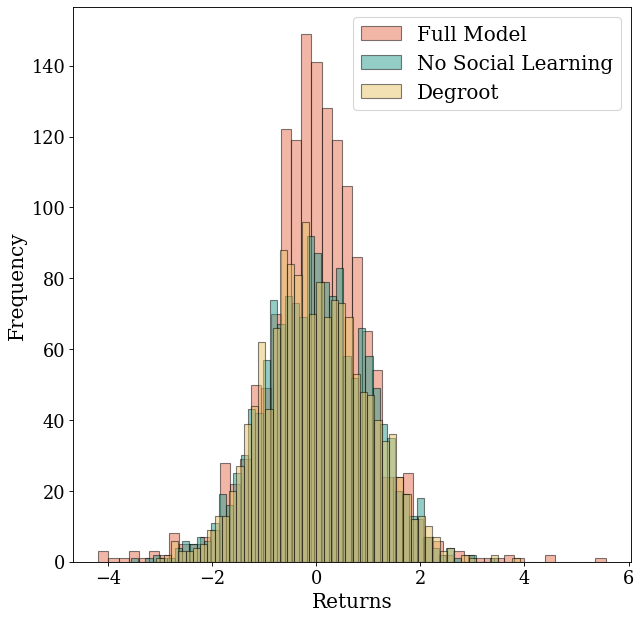

In [9]:
fig, ax = plt.subplots(figsize = (9,9))
#normalize the returns
returns_baseline = (returns_baseline - np.mean(returns_baseline)) / np.std(returns_baseline)
returns_degroot = (returns_degroot - np.mean(returns_degroot)) / np.std(returns_degroot)
returns = (returns - np.mean(returns)) / np.std(returns)
ax.hist(returns, bins=50, alpha=0.5, color="#E76F51", edgecolor='black', density = False, label='Full Model')
ax.hist(returns_baseline, bins=50, alpha=0.5, color='#2A9D8F', edgecolor='black', density = False, label="No Social Learning")
ax.hist(returns_degroot, bins=50, alpha=0.5, color = "#E9C46A", edgecolor = 'black', density = False, label="Degroot")
# #overlay a normal distribution
# x = np.linspace(-4,4,100)
# y = 1/(np.sqrt(2*np.pi)) * np.exp(-0.5*x**2)
# ax.plot(x,y, 'k--', label='Normal Distribution')
#axes labels
ax.set_xlabel('Returns')
ax.set_ylabel('Frequency')
ax.legend()
#save the figure
#plt.savefig('Figures/returns_histogram.png')
plt.show()


In [10]:
print("Skeweness: ", skeweness)
print("Kurtosis: ", kurtosis)
print("Baseline Skeweness: ", np.mean((returns_baseline - np.mean(returns_baseline))**3) / np.std(returns_baseline)**3)
print("Baseline Kurtosis: ", np.mean((returns_baseline - np.mean(returns_baseline))**4) / np.std(returns_baseline)**4)
print("Degroot Skeweness: ", np.mean((returns_degroot - np.mean(returns_degroot))**3) / np.std(returns_degroot)**3)
print("Degroot Kurtosis: ", np.mean((returns_degroot - np.mean(returns_degroot))**4) / np.std(returns_degroot)**4)


Skeweness:  -0.019886328001509735
Kurtosis:  5.514206440842346
Baseline Skeweness:  -0.0679524899810286
Baseline Kurtosis:  3.004827775505357
Degroot Skeweness:  0.12622490655022903
Degroot Kurtosis:  3.102451324404259


In [11]:
# add the parameters we need for the IRF model
params_irf = params.copy()
params_irf["shock_time"] = 10
params_irf["total_steps"] = 30
params_irf["weighting_matrix"] = financial_market.weighting_matrix
params_irf["posterior_variance_vector"] = financial_market.posterior_variance_vector

In [12]:
params_irf["shock_type"] = "information"
financial_market_irf = Market_IRF(params_irf)
# run the market
while financial_market_irf.step_count < params_irf["total_steps"]:
    financial_market_irf.next_step()

In [13]:
params_irf["shock_type"] = "misinformation"
financial_market_irf_misinfo = Market_IRF(params_irf)
# run the market
while financial_market_irf_misinfo.step_count < params_irf["total_steps"]:
    financial_market_irf_misinfo.next_step()

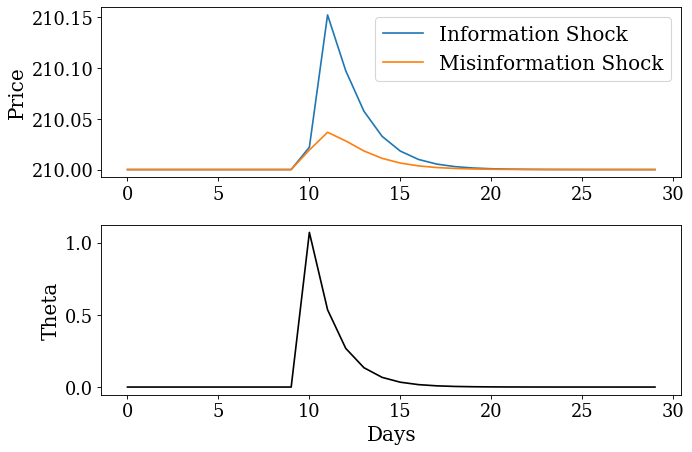

In [14]:
fig, axs = plt.subplots(2,1, figsize = (9,6))
axs[0].plot(np.asarray(financial_market_irf.history_p_t), label = 'Information Shock')
axs[0].set_ylabel('Price')
#twinx the axis
axs[0].plot(np.asarray(financial_market_irf_misinfo.history_p_t), label = 'Misinformation Shock')
axs[0].legend()
axs[1].plot(financial_market_irf.history_theta_t, label = 'Shock', color = "black")
axs[1].set_ylabel('Theta')
axs[1].set_xlabel('Days')

ax.legend()
plt.tight_layout()
# plt.savefig('Figures/irf.png')



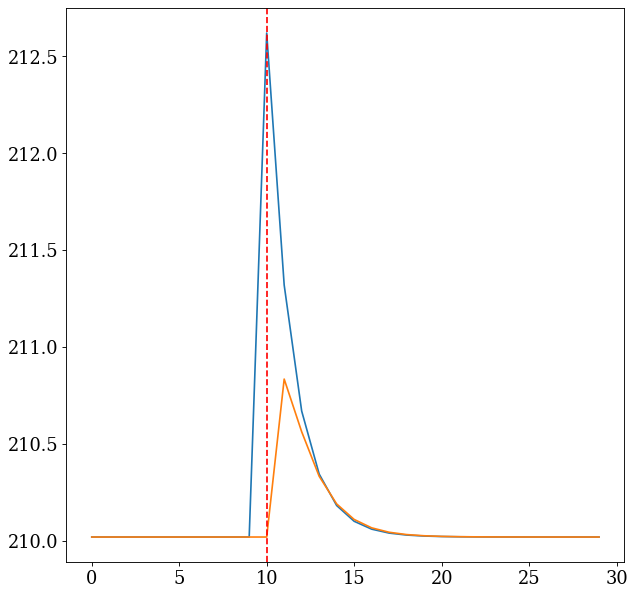

In [18]:
plt.plot(np.asarray(financial_market_irf_misinfo.history_payoff_expectations)[:,-1])
plt.plot(np.asarray(financial_market_irf_misinfo.history_payoff_expectations)[:,-12])
#vertical line at 10
plt.axvline(x=10, color='r', linestyle='--')

In [ ]:
#loop over 30 different seeds
seeds = list(range(10,15))
irfs_info = []
irfs_misinfo = []
for seed in seeds:
    if seed % 10 == 0:
        print("Seed: ", seed)
    params["set_seed"] = seed
    financial_market = Market(params)
    # run the market
    while financial_market.step_count < params["total_steps"]:
        financial_market.next_step()
    params_irf["weighting_matrix"] = financial_market.weighting_matrix
    params_irf["posterior_variance_vector"] = financial_market.posterior_variance_vector
    for info_type in ["information", "misinformation"]:
        params_irf["shock_type"] = info_type
    # run the market
        financial_market_irf = Market_IRF(params_irf)
        while financial_market_irf.step_count < params_irf["total_steps"]:
            financial_market_irf.next_step()
        if info_type == "information":
            irfs_info.append(financial_market_irf.history_p_t)
        else:
            irfs_misinfo.append(financial_market_irf.history_p_t)

Seed:  10
Seed:  20
Seed:  30


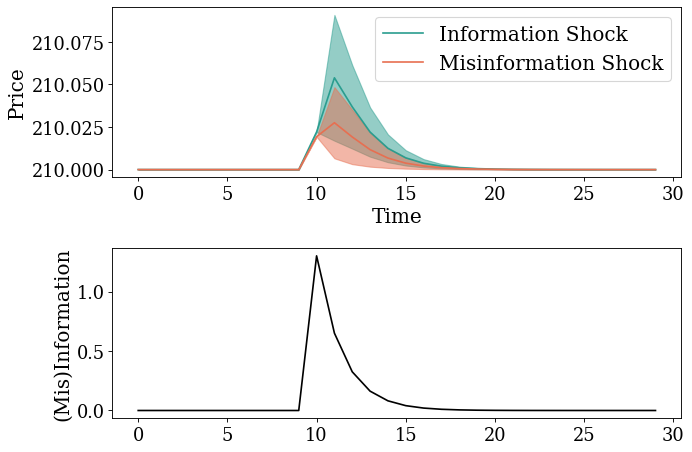

In [17]:
#plot the average IRF and shaded areas for +1-std and -1-std

avg_info_irf = np.mean(irfs_info, axis=0)
std_info_irf = np.std(irfs_info, axis=0)
avg_misinfo_irf = np.mean(irfs_misinfo, axis=0)
std_misinfo_irf = np.std(irfs_misinfo, axis=0)
fig, ax = plt.subplots(2,1, figsize = (9,6))
ax[0].plot(avg_info_irf, label='Information Shock', color = '#2A9D8F')
ax[0].fill_between(range(params_irf["total_steps"]), avg_info_irf - std_info_irf, avg_info_irf + std_info_irf, color = '#2A9D8F', alpha=0.5)
ax[0].plot(avg_misinfo_irf, label='Misinformation Shock', color = '#E76F51')
ax[0].fill_between(range(params_irf["total_steps"]), avg_misinfo_irf - std_misinfo_irf, avg_misinfo_irf + std_misinfo_irf, color = '#E76F51', alpha=0.5)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Price')
ax[1].plot(financial_market_irf.history_gamma_t, label = 'Shock', color = "black")
ax[1].set_ylabel('(Mis)Information')
ax[0].legend()
plt.tight_layout()
plt.savefig('Figures/irf.png')

